In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [3]:
data = pd.read_csv('data/modified_utc_dataset.csv')

# Initial data exploration
print(data.head())

   Duration Protocol Direction State  Source_Type_of_Service  \
0  1.026539      tcp        ->  S_RA                     0.0   
1  1.009595      tcp        ->  S_RA                     0.0   
2  3.056586      tcp        ->  SR_A                     0.0   
3  3.111769      tcp        ->  SR_A                     0.0   
4  3.083411      tcp        ->  SR_A                     0.0   

   Destination_Type_of_Service  Total_Packets  Total_Bytes  Source_Bytes  \
0                          0.0              4          276           156   
1                          0.0              4          276           156   
2                          0.0              3          182           122   
3                          0.0              3          182           122   
4                          0.0              3          182           122   

                                    Label  
0  flow=Background-Established-cmpgw-CVUT  
1  flow=Background-Established-cmpgw-CVUT  
2             flow=Backgro

In [4]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

**Feature selection**
- we have seen the correlation between 'Total_Packets' and 'Total_Bytes' is approximately one.
- The 'label's purpose is to help us identify whether the observation is from a botnet or not.

In [5]:
columns_to_drop = ['Label', 'Total_Bytes']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]

data['botnet'] = data['Label'].apply(lambda x: 1 if 'flow=From-Botnet' in x else 0)

data = data.drop(columns_to_drop, axis =1)

In [6]:
# Encoding categorical features into numerical
data['Protocol'] = data['Protocol'].astype('category').cat.codes
data['Protocol'] = data['Protocol'].astype(np.int32)
data['Direction'] = data['Direction'].astype('category').cat.codes
data['Direction'] = data['Direction'].astype(np.int32)
data['State'] = data['State'].astype('category').cat.codes
data['State'] = data['State'].astype(np.int32)

In [7]:
X = data.drop('botnet', axis =1)
y = data['botnet']

## Feature importance 
**Some features doesn't even have a single observation representing the other class**

In [8]:
# Check for zero variance features and remove them
variance = X.var()
zero_variance_features = variance[variance == 0].index
if len(zero_variance_features) > 0:
    X.drop(columns=zero_variance_features, inplace=True)


In [9]:
# Apply chi-squared test and create a dictionary that holds the p-value and the features.
chi_scores, p_values = chi2(X, y)
chi2_results = {feature: p_value for feature, p_value in zip(X.columns, p_values)}

print(chi2_results)

{'Duration': 0.0, 'Protocol': 5.052265651175802e-59, 'Direction': 0.0, 'State': 0.0, 'Source_Type_of_Service': 7.057826559746228e-25, 'Destination_Type_of_Service': 0.00019255073119190503, 'Total_Packets': 0.0, 'Source_Bytes': 0.0}


In [10]:
# Normalize the feature data (if necessary for the specific context)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Training LogisticRegression...
testing LogisticRegression finished.
LogisticRegression Performance:
Time Taken: 16.82 seconds
Accuracy: 0.9818390427798721
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC: 0.5
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    299510
           1       0.00      0.00      0.00      5540

    accuracy                           0.98    305050
   macro avg       0.49      0.50      0.50    305050
weighted avg       0.96      0.98      0.97    305050



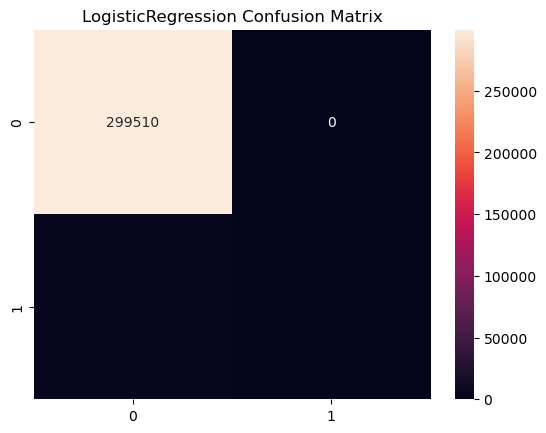

Training DecisionTree...
testing DecisionTree finished.
DecisionTree Performance:
Time Taken: 84.56 seconds
Accuracy: 0.9854187838059335
Precision: 0.7104857363145721
Recall: 0.33267148014440434
F1-Score: 0.4531595770838456
ROC-AUC: 0.6650820256720152
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    299510
           1       0.71      0.33      0.45      5540

    accuracy                           0.99    305050
   macro avg       0.85      0.67      0.72    305050
weighted avg       0.98      0.99      0.98    305050



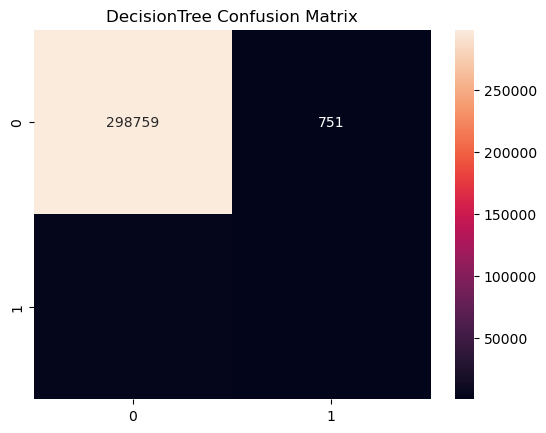

Training KNN...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models and hyperparameters for GridSearchCV
models = {
    'LogisticRegression': LogisticRegression(),
    #'RandomForest': RandomForestClassifier(),
    #'SVC': SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

params = {
    'LogisticRegression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
    #'RandomForest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]},
    #'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'DecisionTree': {'max_depth': [None, 10, 20, 30]},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

}

# Dictionary to store model performance metrics
model_metrics = {
    'Model': [],
    'Time Taken': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Hyperparameter tuning and model evaluation
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    start_time = time.time()
    grid = GridSearchCV(model, params[model_name], cv=5, scoring='roc_auc')
    grid.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = grid.best_estimator_

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    time_taken = end_time - start_time
    print(f"testing {model_name} finished.")

    # Store metrics in the dictionary
    model_metrics['Model'].append(model_name)
    model_metrics['Time Taken'].append(time_taken)
    model_metrics['Accuracy'].append(accuracy)
    model_metrics['Precision'].append(precision)
    model_metrics['Recall'].append(recall)
    model_metrics['F1-Score'].append(f1)

    print(f"{model_name} Performance:")
    print(f"Time Taken: {time_taken:.2f} seconds")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Save the best model
    joblib.dump(best_model, f'{model_name}_best_model.pkl')

# Create a DataFrame from the model_metrics dictionary
metrics_df = pd.DataFrame(model_metrics)

# Plotting the metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(x='Model', y='Time Taken', data=metrics_df, ax=axes[0, 0])
axes[0, 0].set_title('Time Taken by Each Model')

sns.barplot(x='Model', y='Accuracy', data=metrics_df, ax=axes[0, 1])
axes[0, 1].set_title('Accuracy of Each Model')

sns.barplot(x='Model', y='Precision', data=metrics_df, ax=axes[1, 0])
axes[1, 0].set_title('Precision of Each Model')

sns.barplot(x='Model', y='F1-Score', data=metrics_df, ax=axes[1, 1])
axes[1, 1].set_title('F1-Score of Each Model')

plt.tight_layout()
plt.show()
